In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('train_case2.csv', ';')
df.head()

<ipython-input-2-863884a1958a>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv('train_case2.csv', ';')


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),
                                                    df['cardio'], random_state=0)

<ipython-input-3-5906ed3f4c5a>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))

for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))

for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [ ]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
def classification(model):
  classifier = Pipeline([
    ('features',feats),
    ('classifier', model(random_state = 42)),
])


#запустим кросс-валидацию
  cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
  cv_score = np.mean(cv_scores)
  cv_score_std = np.std(cv_scores)


#обучим пайплайн на всем тренировочном датасете
  classifier.fit(X_train, y_train)
  y_score = classifier.predict_proba(X_test)[:, 1]
  return cv_score, cv_score_std, y_score

In [ ]:
def plot(test, score):
  sns.set(font_scale=1.5)
  sns.set_color_codes("muted")

  plt.figure(figsize=(10, 8))
  fpr, tpr, thresholds_ = roc_curve(test, score, pos_label=1)
  lw = 2
  plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
  plt.plot([0, 1], [0, 1])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.savefig("ROC.png")
  return plt.show()

# LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression

In [ ]:
cv_score, cv_score_std, y_score = classification(model)
print(f'CV score is {cv_score}+-{cv_score_std}')

CV score is 0.7867401104915408+-0.00852135511666111


In [ ]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3869370891147378, F-Score=0.730, Precision=0.647, Recall=0.838


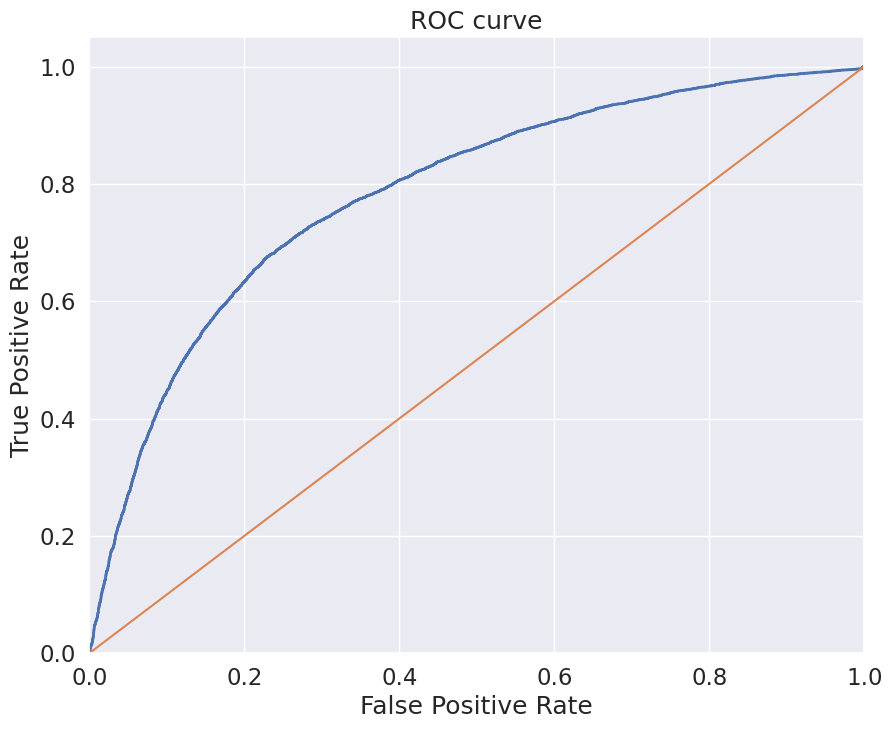

(0.7840347790421852, None)

In [ ]:
roc_auc = roc_auc_score(y_test, y_score)
roc_auc_score(y_test, y_score), plot(y_test, y_score)

In [ ]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 152974200


In [ ]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC', 'rubl_ML'])
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML


In [ ]:
metrics_df = metrics_df.append({
    'model': 'LogisticRegression',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, ignore_index=True)

metrics_df

<ipython-input-62-5b833a45d9eb>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,152974200


# LightGBM

In [ ]:
! pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
model = LGBMClassifier

In [ ]:
cv_score, cv_score_std, y_score = classification(model)
print(f'CV score is {cv_score}+-{cv_score_std}')

CV score is 0.8024230111465757+-0.006885787188310477


In [ ]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3447966167909033, F-Score=0.740, Precision=0.661, Recall=0.840


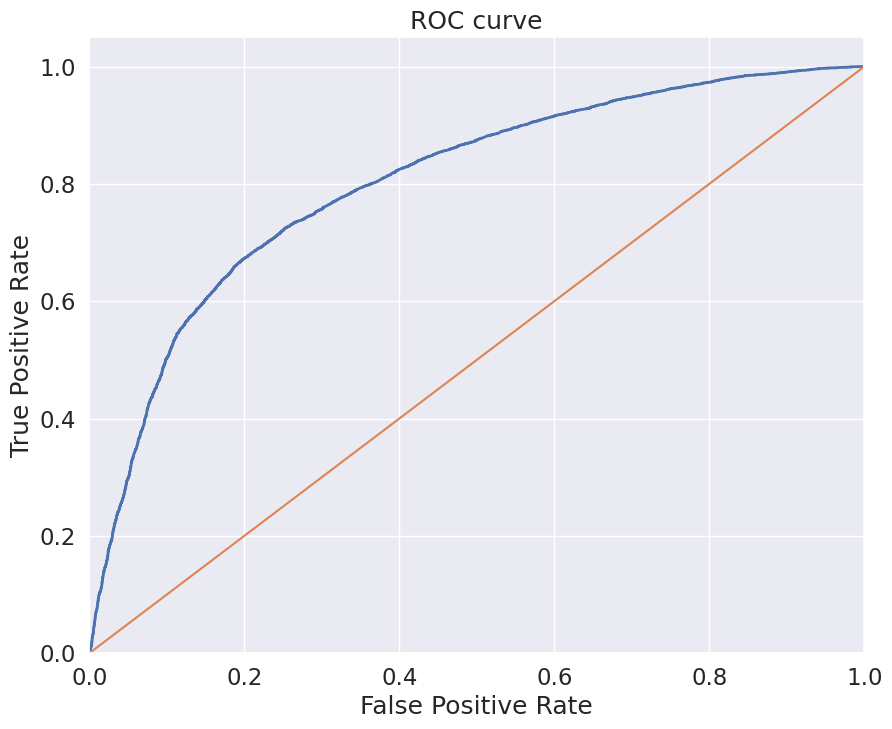

(0.8016890681003584, None)

In [ ]:
roc_auc = roc_auc_score(y_test, y_score)
roc_auc_score(y_test, y_score), plot(y_test, y_score)

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 152604200


In [ ]:
metrics_df = metrics_df.append({
    'model': 'LGBMClassifier',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, ignore_index=True)

metrics_df

<ipython-input-68-f8bed67eb92c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,152974200
1,LGBMClassifier,0.344797,0.739561,0.660803,0.839631,0.801689,152604200


# RandomForestClassfier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier

In [ ]:
cv_score, cv_score_std, y_score = classification(model)
print(f'CV score is {cv_score}+-{cv_score_std}')

CV score is 0.7734501681056019+-0.007171140345435727


In [ ]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.35, F-Score=0.719, Precision=0.643, Recall=0.816


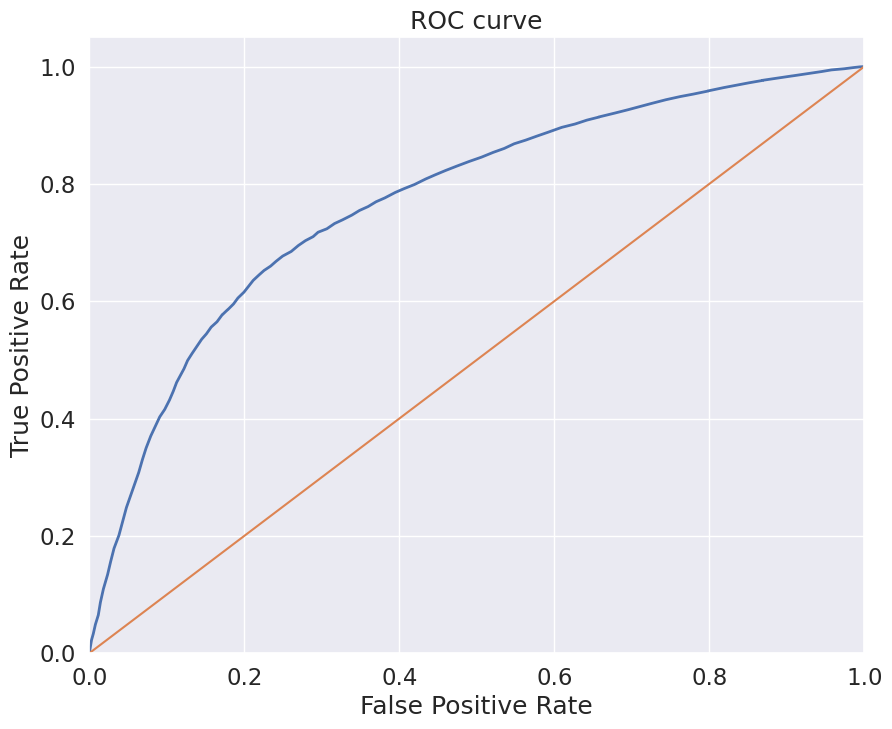

(0.7710366181802983, None)

In [ ]:
roc_auc = roc_auc_score(y_test, y_score)
roc_auc_score(y_test, y_score), plot(y_test, y_score)

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 153699400


In [ ]:
metrics_df = metrics_df.append({
    'model': 'RandomForestClassifier',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, ignore_index=True)

metrics_df

<ipython-input-74-ab3a1c8e0a11>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,152974200
1,LGBMClassifier,0.344797,0.739561,0.660803,0.839631,0.801689,152604200
2,RandomForestClassifier,0.350000,0.718863,0.642669,0.815553,0.771037,153699400


Лучше остальных справилась LGBM модель.

In [ ]:
model = LGBMClassifier

In [ ]:
cv_score, cv_score_std, y_score = classification(model)

In [ ]:
def business_threshold_calibrate(y_test, y_score,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    rubl_ML_ = 1_000_000_000

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment

        if rubl_ML < rubl_ML_:
            business_threshold = opt_buisness_tr

            rubl_ML_ = rubl_ML

        rs.append(rubl_ML)


    print('расходы, если использовать МЛ:', rubl_ML_)

    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

расходы, если использовать МЛ: 152388000


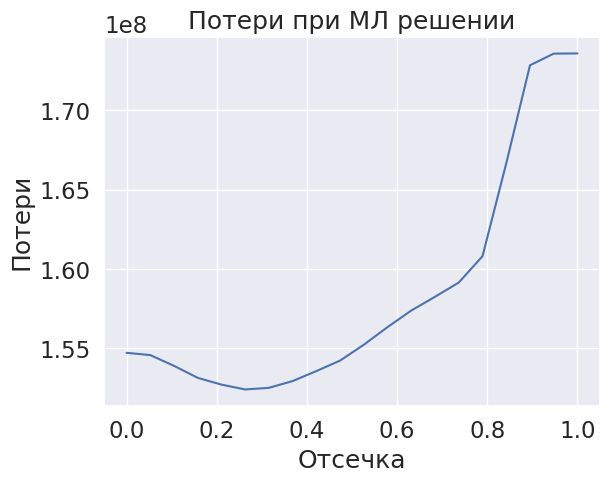

уровень порога по бизнес метрике 0.2631578947368421


In [ ]:
busines_tr = business_threshold_calibrate(y_test,
                                          y_score,
                                          rubl_test=1400,
                                          rubl_early_treatment=15000,
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)